# Example 5 - `stripy` smoothing operations

SRFPACK is a Fortran 77 software package that constructs a smooth interpolatory or approximating surface to data values associated with arbitrarily distributed points. It employs automatically selected tension factors to preserve shape properties of the data and avoid overshoot and undershoot associated with steep gradients.

Here we demonstrate how to access SRFPACK smoothing through the `stripy` interface.

## Notebook contents

   - [Computational mesh](#Define-a-computational-mesh)
   - [Function with noise](#Analytic-function-with-noise-and-short-wavelengths)
   - [Smoothing operator](#Smoothing-operations)
   - [Results of smoothing](#Results-of-smoothing-with-different-value-of-sm)
   

The next example is [Ex6-Scattered-Data](./Ex6-Scattered-Data.ipynb)

## Define a computational mesh

Use the (usual) icosahedron with face points included.

In [1]:
import stripy as stripy

xmin = 0.0
xmax = 10.0
ymin = 0.0
ymax = 10.0
extent = [xmin, xmax, ymin, ymax]

spacingX = 0.2
spacingY = 0.2

mesh = stripy.cartesian_meshes.elliptical_mesh(extent, spacingX, spacingY, refinement_levels=1)
mesh = stripy.Triangulation(mesh.x, mesh.y, permute=True)
print(mesh.npoints)

1744


## Analytic function with noise and short wavelengths

Define a relatively smooth function that we can interpolate from the coarse mesh to the fine mesh and analyse

In [2]:
import numpy as np

def analytic(xs, ys, k1, k2):
     return  np.cos(k1*xs) * np.sin(k2*ys) 
    
def analytic_noisy(xs, ys, k1, k2, noise, short):
     return  np.cos(k1*xs) * np.sin(k2*ys) + \
             short * (np.cos(k1*5.0*xs) * np.sin(k2*5.0*ys)) + \
             noise * np.random.random(xs.shape)

# def analytic_ddlon(xs, ys, k1, k2):
#      return -k1 * np.sin(k1*xs) * np.sin(k2*ys) / np.cos(ys)

# def analytic_ddlat(xs, ys, k1, k2):
#      return k2 * np.cos(k1*xs) * np.cos(k2*ys) 


analytic_sol   = analytic(mesh.x, mesh.y, 0.1, 1.0)
analytic_sol_n = analytic_noisy(mesh.x, mesh.y, 0.1, 1.0, 0.2, 0.0)

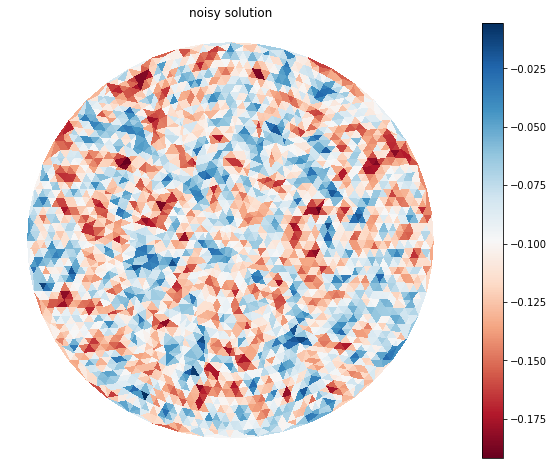

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def axis_mesh_field(fig, ax, mesh, field, label):

    ax.axis('off')

    x0 = mesh.x
    y0 = mesh.y
    
    trip = ax.tripcolor(x0, y0, mesh.simplices, field, cmap=plt.cm.RdBu)
    fig.colorbar(trip, ax=ax)
    
    ax.set_title(str(label))
    return

fig = plt.figure(figsize=(10, 8), facecolor="none")
ax = fig.add_subplot(111)
axis_mesh_field(fig, ax, mesh, analytic_sol-analytic_sol_n, "noisy solution")

## Smoothing operations 

The `Triangulation.smoothing` method directly wraps the SRFPACK smoother that smooths a surface f described 
by values on the mesh vertices to find a new surface f' (also described on the mesh vertices) by choosing nodal function values and gradients to minimize the linearized curvature of F subject to a bound on the deviation from the data values.

In [4]:
help(mesh.smoothing)

Help on method smoothing in module stripy.cartesian:

smoothing(f, w, sm, smtol, gstol, sigma=None) method of stripy.cartesian.Triangulation instance
    Smooths a surface `f` by choosing nodal function values and gradients to
    minimize the linearized curvature of F subject to a bound on the
    deviation from the data values. This is more appropriate than interpolation
    when significant errors are present in the data.
    
    Args:
        f : array of floats, shape (n,)
            field to apply smoothing on
        w : array of floats, shape (n,)
            weights associated with data value in `f`
            `w[i] = 1/sigma_f**2` is a good rule of thumb.
        sm : float
            positive parameter specifying an upper bound on Q2(f).
            generally `n-sqrt(2n) <= sm <= n+sqrt(2n)`
        smtol : float [0,1]
            specifies relative error in satisfying the constraint
            `sm(1-smtol) <= Q2 <= sm(1+smtol)` between 0 and 1.
        gstol : float
  

In [5]:
stripy_smoothed,  dds, err = mesh.smoothing(analytic_sol_n, np.ones_like(analytic_sol_n), 10.0, 0.01, 0.01)
stripy_smoothed2, dds2, err = mesh.smoothing(analytic_sol_n, np.ones_like(analytic_sol_n), 1.0, 0.1, 0.01)
stripy_smoothed3, dds3, err = mesh.smoothing(analytic_sol_n, np.ones_like(analytic_sol_n), 20.0, 0.1, 0.01)

delta_n  = analytic_sol_n - stripy_smoothed
delta_ns = analytic_sol   - stripy_smoothed

delta_n2  = analytic_sol_n - stripy_smoothed2
delta_ns2 = analytic_sol   - stripy_smoothed2

delta_n3  = analytic_sol_n - stripy_smoothed3
delta_ns3 = analytic_sol   - stripy_smoothed3

In [6]:
stripy_smoothed, dds

(array([-0.701736  , -0.63498056, -0.7535951 , ...,  0.14401424,
        -0.06993694, -0.15783575], dtype=float32),
 [array([ 0.06552518,  0.01060782,  0.01183237, ..., -0.01502026,
          0.00751309,  0.00132097], dtype=float32),
  array([ 0.24114494,  0.40533134,  0.07099389, ..., -0.3999952 ,
         -0.3359225 , -0.2729508 ], dtype=float32)])

## Results of smoothing with different value of `sm`

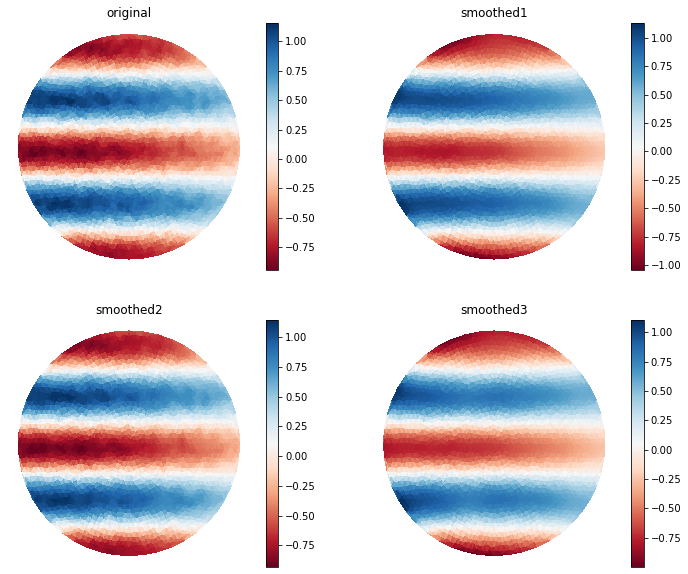

In [7]:
fig, ax = plt.subplots(2,2, figsize=(12, 10), facecolor="none")

axis_mesh_field(fig, ax[0,0], mesh, analytic_sol_n, label="original")
axis_mesh_field(fig, ax[0,1], mesh, stripy_smoothed, label="smoothed1")
axis_mesh_field(fig, ax[1,0], mesh, stripy_smoothed2, label="smoothed2")
axis_mesh_field(fig, ax[1,1], mesh, stripy_smoothed3, label="smoothed3")

plt.show()

The next example is [Ex6-Scattered-Data](./Ex6-Scattered-Data.ipynb)

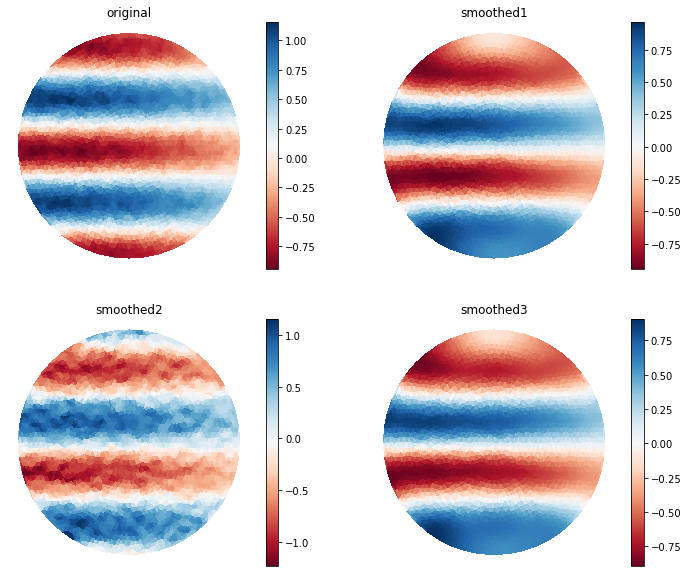

In [8]:
fig, ax = plt.subplots(2,2, figsize=(12,10), facecolor="none")

axis_mesh_field(fig, ax[0,0], mesh, analytic_sol_n, label="original")
axis_mesh_field(fig, ax[0,1], mesh, dds[1], label="smoothed1")
axis_mesh_field(fig, ax[1,0], mesh, dds2[1], label="smoothed2")
axis_mesh_field(fig, ax[1,1], mesh, dds3[1], label="smoothed3")

plt.show()

The next notebook is [Ex6-Scattered-Data](./Ex6-Scattered-Data.ipynb)